In [6]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
import unicodedata
from transformers import HfArgumentParser, set_seed, T5Tokenizer, BartTokenizer


import re

def fix_encoding_errors(data):
    # This pattern matches one or more digits followed by an accented 'a'
    pattern = r'(\d+)Â'

    # See analysis in narrativeqa_encoding.ipynb
    data["source"] = (
        data["source"]
        .replace("â\x80\x94", ", ")
        .replace("Â\xa0â\x80\x93", " -")
        .replace("â\x80\x93", "-")
        .replace("â\x80\x99", "'")
        .replace("â\x80\x9d", "")
        .replace("â\x80\x9c", "")
        .replace("Ă˛", "")
        .replace("Ă\x89", "e")
        .replace("ÂŁ", "$")
        .replace("â\x80\x89", "")
        .replace("Ĺ\x8d", "o")
        .replace("â\x82Ź", "€")
    )
    data["source"] = re.sub(pattern, r'\1', data["source"])

    data["target"] = (
        data["target"]
        .replace("â\x80\x94", ", ")
        .replace("Â\xa0â\x80\x93", " -")
        .replace("â\x80\x93", "-")
        .replace("â\x80\x99", "'")
        .replace("â\x80\x9d", "")
        .replace("â\x80\x9c", "")
        .replace("Ă˛", "")
        .replace("Ă\x89", "e")
        .replace("ÂŁ", "$")
        .replace("â\x80\x89", "")
        .replace("Ĺ\x8d", "o")
        .replace("â\x82Ź", "€")
    )
    data["target"] = re.sub(pattern, r'\1', data["target"])

    return data

def contain_question_mark(data):
    return data["target"][-1].rstrip() == "?"


def normalise(data):
    # Lowercase the text
    data["source"] = data["source"].lower()
    data["target"] = data["target"].lower()

    # Remove new line characters
    data["source"] = data["source"].replace("\n", " ")

    # Resolve accented characters
    data["source"] = "".join(
        c
        for c in unicodedata.normalize("NFD", data["source"])
        if unicodedata.category(c) != "Mn"
    )
    data["target"] = "".join(
        c
        for c in unicodedata.normalize("NFD", data["target"])
        if unicodedata.category(c) != "Mn"
    )

    return data

def categorise_dataset(data):
    target = data["target"].lower()
    if any(word in target for word in ["what"]):
        data["category"] = "description"
    elif any(
        word in target
        for word in [
            "where",
            "when",
            "who",
            "how many",
            "how much",
            "which",
            "how long",
        ]
    ):
        data["category"] = "recall"
    elif any(
        word in target
        for word in ["how did", "how does", "how do", "compute", "calculate"]
    ):
        data["category"] = "method"
    elif any(word in target for word in ["why"]):
        data["category"] = "explanation"

    return data

def remove_na_category(data):
    return data["category"] != "NA"

In [4]:
narrative_data = (
  load_dataset("narrativeqa", trust_remote_code=True, split="train+validation+test")
  .select_columns(["document", "question"])
  .map(
      lambda x: {
          "document": x["document"]["summary"]["text"],
          "question": x["question"]["text"],
      }
  )
  .rename_columns({"document": "source", "question": "target"})
  .map(fix_encoding_errors)
)

narrative_data = narrative_data.add_column(
  "category", ["NA"] * len(narrative_data)
)

narrative_data = (
  narrative_data.filter(contain_question_mark)
  .map(normalise)
  .map(categorise_dataset)
  .filter(remove_na_category)
)

Filter:   0%|          | 0/46765 [00:00<?, ? examples/s]

Map:   0%|          | 0/44548 [00:00<?, ? examples/s]

Map:   0%|          | 0/44548 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44548 [00:00<?, ? examples/s]

In [19]:
narrative_data.to_csv("naqa.csv")

Creating CSV from Arrow format:   0%|          | 0/44 [00:00<?, ?ba/s]

150353891

In [8]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

def convert_to_features(x):
    input_encodings = tokenizer.batch_encode_plus(
        x["source"],
        add_special_tokens=True,
    )
    target_encodings = tokenizer.batch_encode_plus(
        x["target"],
        add_special_tokens=True,
    )

    encodings = {
        "input_ids": input_encodings["input_ids"],
        "labels": target_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
    }

    return encodings

tokenized_dataset = narrative_data.map(
    convert_to_features,
    batched=True,
    batch_size=2000,
    remove_columns=["source", "target"],
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/43612 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1286 > 512). Running this sequence through the model will result in indexing errors


In [9]:
def calculate_length(data):
  data["input length"] = len(data["input_ids"])

  return data


tokenized_dataset = tokenized_dataset.add_column(
  "input length", ["NA"] * len(tokenized_dataset)
)

tokenized_dataset = tokenized_dataset.map(calculate_length)




Map:   0%|          | 0/43612 [00:00<?, ? examples/s]

In [13]:
tokenized_dataset = tokenized_dataset.select_columns(["input length"])

tokenized_dataset.to_csv("tokenized.csv")

Creating CSV from Arrow format:   0%|          | 0/44 [00:00<?, ?ba/s]

193823

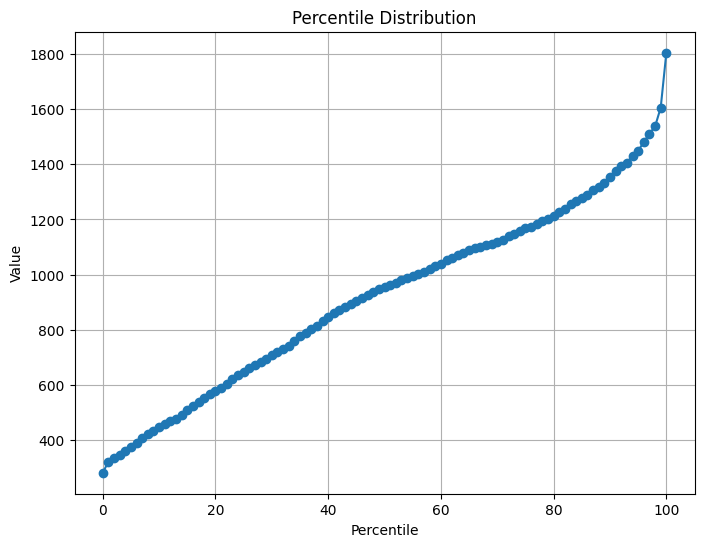

In [18]:
import numpy as np


# Step 2: Extract features and labels
length = tokenized_dataset['input length']

# Step 3: Convert to numpy arrays
np_array = np.array(length)

import matplotlib.pyplot as plt


# Step 1: Calculate percentiles
percentiles = np.percentile(np_array, np.arange(0, 101, 1))  # Calculate percentiles from 0 to 100

# Step 2: Plot the percentile distribution
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 101, 1), percentiles, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Value')
plt.title('Percentile Distribution')
plt.grid(True)
plt.show()
